In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pointprocesses as ppr

In [3]:
import torch

# Données synthétiques

In [4]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [20]:
import itertools
mu = 1.0
tmax = 10.0
alpha = 0.4
beta  = 1.5

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha)))

Expected avg evt no. 16.667


In [29]:
n_traj = 400
sample_trajectories = [ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)) for _ in range(n_traj)]

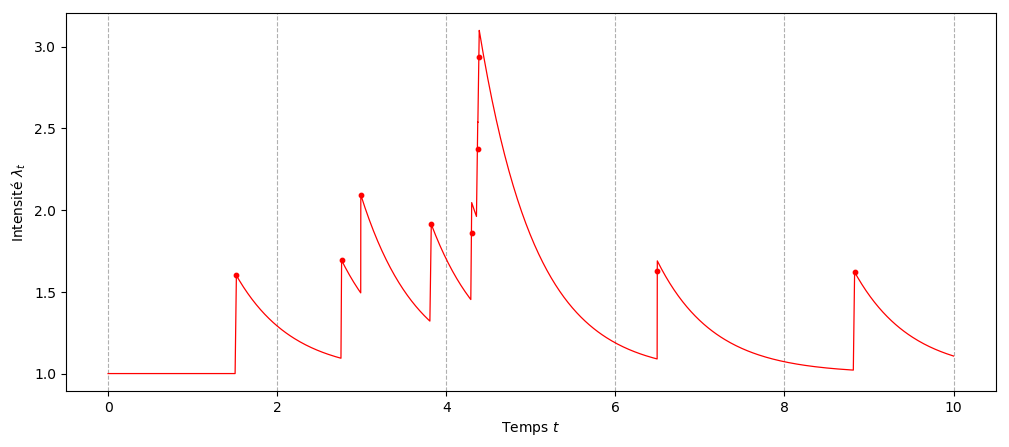

In [30]:
one_traj = sample_trajectories[0]
fig, ax = plt.subplots(1,1, figsize=(12,5), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

In [31]:
print("Number of samples: \t\t%d" % len(sample_trajectories))
seq_lengths = torch.LongTensor([s.shape[0] for s in sample_trajectories])+1
input_size = seq_lengths.max().item()
print("Input size max. traj. length: \t%d" % input_size)
print("tmax = %.3f"  % tmax)
data_array = np.stack([
    np.pad(s[:,0], ((0, input_size - s.shape[0] - 1)), 'constant') for s in sample_trajectories
])
data_tensor = torch.from_numpy(data_array).to(torch.float32)

# Add a beginning-of-sequence event:
data_tensor = torch.cat((torch.zeros(data_tensor.shape[0],1), data_tensor), dim=1)

Number of samples: 		400
Input size max. traj. length: 	41
tmax = 10.000


Text(0, 0.5, 'Number')

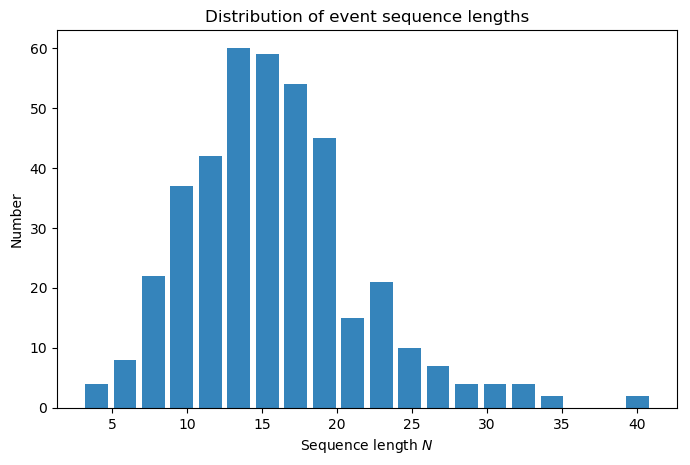

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
ax.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(2/5)), rwidth=0.8, alpha=0.9)
ax.set_title('Distribution of event sequence lengths')
ax.set_xlabel('Sequence length $N$')
ax.set_ylabel('Number')

In [25]:
data_tensor.shape

torch.Size([400, 35])

The first dimension is for time, the second for the sample.

## Neural net

In [33]:
import torch
import torch.nn as nn
from torch import optim

In [34]:
device = torch.device("cpu")
print(device)

cpu


In [35]:
torch.manual_seed(1)

The intensity process is given by
$$
    \lambda_k(t) = f_k(\mathbf w_\alpha\mathbf h(t) + \mathbf b_\alpha)
$$
with $\mathbf h(t)$ the hidden state, defined from the cell state $\mathbf c(t)$ :
$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i].
$$

with
$$
    \mathbf c(t) = \bar{\mathbf c}_{i+1} + (\mathbf c_{i+1} - \bar{\mathbf c}_{i+1})\exp\left(-\delta_{i+1}(t-t_i)\right),\quad t\in(t_{i-1}, t_i].
$$

In [193]:
from models import NeuralCTLSTM
import tqdm

In [194]:
# We use mini-batches to train on our data
BATCH_SIZE = 40
print("Batch size: %d" % BATCH_SIZE)
print("Training sample size: %d" % data_tensor.size(0))
print("Splitting into batches of %d" % BATCH_SIZE)
split_into_batches = data_tensor.split(BATCH_SIZE, dim=0)
num_of_batches = len(split_into_batches)
print("No. of batches: %d" % num_of_batches)

hidden_size = 8
learn_rate = 0.0008

nhlstm = NeuralCTLSTM(hidden_size)
optimizer = optim.SGD(nhlstm.parameters(), lr=learn_rate)

Batch size: 40
Training sample size: 400
Splitting into batches of 40
No. of batches: 10


In [261]:
from train_functions import train_neural_ctlstm

In [196]:
# batch_range = tqdm.trange(num_of_batches)
# batch_range = tqdm.trange(data_tensor.size(0))
train_size = 400
batch_range = tqdm.tqdm_notebook(range(train_size))
loss_hist = []
for i in batch_range:
    batch_range.set_description("Batch %d" % (i+1))
    # sample's event times
    event_times = data_tensor[i]
    loss, hists_ = train_neural_ctlstm(nhlstm, optimizer, event_times, seq_lengths[i], input_size, tmax)
    loss_val = loss.item()
    batch_range.set_postfix(loss=loss_val)
    loss_hist.append(loss_val) # record the loss value

Each training loop:
* reinitializes the hidden states
* zeroes the gradients
* computes the loss

Text(0.5, 0, 'Training samples')

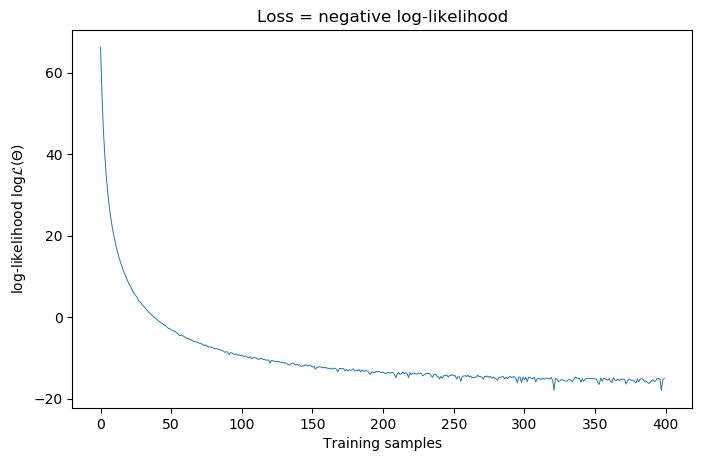

In [219]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
lineopts = {
    "linewidth": 0.7
}
ax.plot(range(train_size), loss_hist, **lineopts)
ax.set_title("Loss = negative log-likelihood")
ax.set_ylabel(r'log-likelihood $\log\mathcal{L}(\Theta)$')
ax.set_xlabel("Training samples")

In [179]:
import datetime

In [180]:
ts = '{:%Y%m%d-%H%M%S}'.format(datetime.datetime.now())

flname = '{:}-{:}.pth'.format(nhlstm.__class__.__name__, ts)
print(flname)
fpath = '../saved_models/{:}'.format(flname)
print(fpath)

torch.save(nhlstm.state_dict(), fpath)

NeuralCTLSTM-20181106-094828.pth
../saved_models/NeuralCTLSTM-20181106-094828.pth


In [198]:
from models import EventGen

In [199]:
nhlstm.eval()
print(nhlstm.training)

False


In [200]:
neural_gen = EventGen(nhlstm)

In [253]:
neural_gen.generate_sequence(tmax)

[0.18908420205116272,
 0.9877682626247406,
 1.4487067759037018,
 3.6190930902957916,
 3.653043895959854,
 5.062111526727676,
 5.095845300704241,
 6.212437231093645,
 6.353768516331911,
 6.9558855183422565]

In [229]:
print(len(neural_gen.sequence_))

7


In [230]:
neural_gen.hidden_hist[-1]

{'hidden': tensor([[ 0.2950, -0.1565, -0.4149, -0.1792, -0.2378,  0.0540, -0.2048,  0.0131]]),
 'cell': tensor([[ 0.7248, -0.2676, -1.0708, -0.3338, -0.4090,  0.1196, -0.4365,  0.0329]]),
 'cell_target': tensor([[ 0.6611, -0.2214, -0.6001, -0.2267, -0.6721,  0.1001, -0.3709,  0.0355]]),
 'cell_decay': tensor([[0.2903]]),
 'output': tensor([[0.4759, 0.5987, 0.5254, 0.5564, 0.6135, 0.4533, 0.4986, 0.3988]])}

In [231]:
def plot_intensity_for_seq():
    sequence = neural_gen.sequence_
    hidden_hist = neural_gen.hidden_hist
    tls = np.linspace(0, tmax, 100)
    tls = np.sort(np.append(tls, sequence))
    interv_counter = 0
    y_vals = np.zeros_like(tls[:-1])
    for i in range(len(tls)):
        t = tls[i]
        if t > sequence[-1]:
            tls = tls[:i]
            y_vals = y_vals[:i]
            break
        while t > sequence[interv_counter]:
            interv_counter += 1
        c_t = hidden_hist[interv_counter]['cell']
        c_target = hidden_hist[interv_counter]['cell_target']
        output = hidden_hist[interv_counter]['output']
        decay = hidden_hist[interv_counter]['cell_decay']
        hidden_t = output * torch.tanh(
            c_target + (c_t - c_target)*torch.exp(-decay*(t - sequence[interv_counter]))
        )
        with torch.no_grad():
            y_vals[i] = nhlstm.activation(nhlstm.w_alpha(hidden_t)).item()
    
    fig, ax = plt.subplots(1,1, figsize=(12,6), dpi=100)
    ax.plot(tls, y_vals, linewidth=0.7)
    for t in sequence:
        ax.axvline(t, ymin=0.0, ymax=y_vals.max(), linewidth=0.6,
                   linestyle='--',
                   alpha=0.5, c='k', zorder=-1)
    ax.scatter(sequence, y_vals.min()+ np.zeros_like(sequence), s=15, alpha=0.8, zorder=1)
    ax.set_xlabel("Time $t$")
    ax.set_ylabel("Intensity $\lambda_t$")
    ax.set_title("Intensity plot for neural Hawkes process")

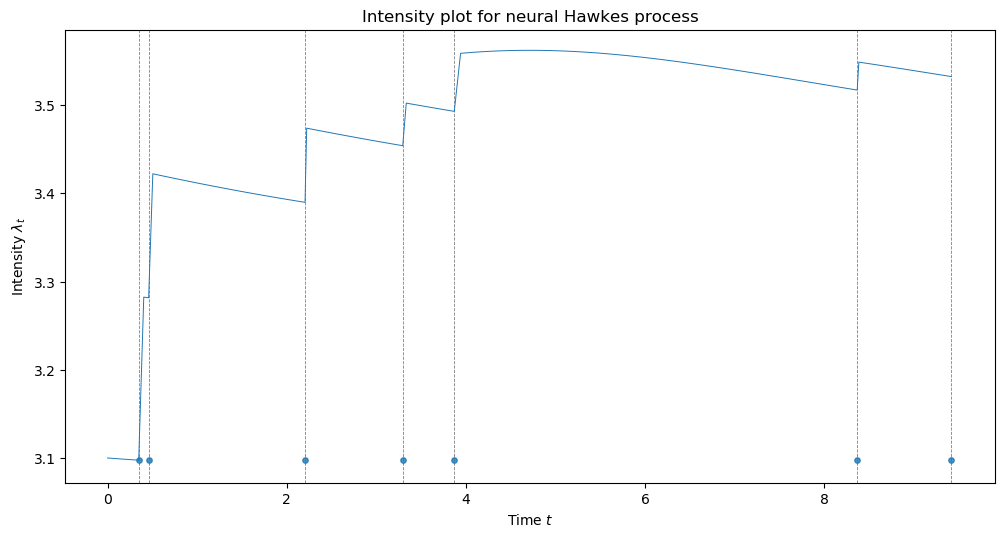

In [232]:
plot_intensity_for_seq()

In [149]:
x.dot(x)

tensor(4.5233)